# Linear regression
In this notebook, we do regression for the problem of predicting mean activity based on non-wearable features taken from the UK biobank. We use the L1 and L2 norms, hence we use elastic-net.

In [3]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)
%cd ..
%cd ..

/cdthome/xqe353/Custom Encodings
/cdthome/xqe353


In [4]:
from accel.constants import DATA_DIR
from accel.read_data import prep_data

## Data prep

In [5]:
# Path to dataset
PATH = '/cdtshared/wearables/students/group5/'

# Features from biobank
X_train = pd.read_pickle(PATH+"XtrainPCAELLIE.pkl")
X_val = pd.read_pickle(PATH+"XvalPCAELLIE.pkl")
X_test = pd.read_pickle(PATH+"XtestPCAELLIE.pkl")
# Outcome
y_train = pd.read_pickle(PATH+"ytrainPCAELLIE.pkl")
y_val = pd.read_pickle(PATH+"yvalPCAELLIE.pkl")
y_test = pd.read_pickle(PATH+"ytestPCAELLIE.pkl")

In [6]:
X_train.shape

(60829, 60)

## Model

In [7]:
from sklearn.linear_model import ElasticNet, LinearRegression 
from sklearn.metrics import r2_score, mean_squared_error

Since we only have two parameters to search through, we can do a random-search for a number of iterations and then plot the results in 2D. The objective function is:
$$
        1 / (2 \cdot n_\text{samples}) \cdot ||y - Xw||^2_2 \\
        + \text{alpha} * \text{l1_ratio} \cdot ||w||_1  \\
        + 0.5 * \text{alpha} * (1 - \text{l1_ratio}) \cdot ||w||^2_2
$$
When the l1_ratio is close to 1, we have mainly l1 regularisation.

In [8]:
alphas = []
l1_ratios = []
r2_scores = []
mse_scores = []
its = 200

In [9]:
for i in range(its):
    alpha = np.random.exponential(0.1) # random exponentially distributed number
    l1_ratio = np.random.uniform(0, 1) # random uniform number between 0 and 1
    alphas.append(alpha)
    l1_ratios.append(l1_ratio)
    # train model on training and then assess on validation
    clf = ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    r2_scores.append(r2_score(y_val, y_pred))
    mse_scores.append(mean_squared_error(y_val, y_pred))

##  Visualise output

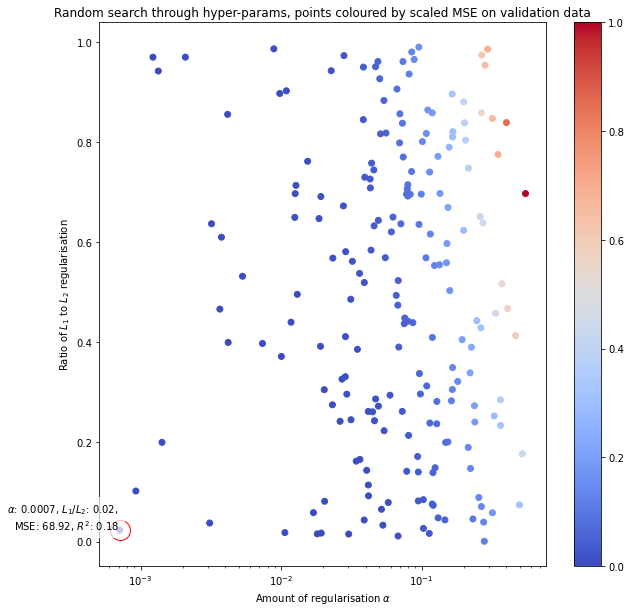

In [10]:
mse = np.array(mse_scores)
r2 = np.array(r2_scores)
scaled_mse = (mse - np.min(mse)) / (np.max(mse) - np.min(mse))
arg_min = np.argmin(scaled_mse)

plt.figure(figsize=(10,10))
plt.scatter(alphas, l1_ratios, c=scaled_mse, cmap="coolwarm")
plt.xlabel("Amount of regularisation $ \\alpha $")
plt.ylabel("Ratio of $L_1$ to $L_2$ regularisation")
plt.xscale("log")
plt.title("Random search through hyper-params, points coloured by scaled MSE on validation data")
plt.colorbar()

# highlight hyper-params with min MSE
a, l1 = alphas[arg_min], l1_ratios[arg_min]
t = plt.text(a,l1,
             f"$\\alpha$: {np.round(a,4)}, $L_1/L_2$: {np.round(l1,2)}, \nMSE: {np.round(mse[arg_min],2)}, $R^2$: {np.round(r2[arg_min],2)}",
            ha = "right")
t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))
plt.plot(a,l1,"ro",mfc='none',markersize=20)

plt.show()


Assess model performance

In [11]:
from accel.training import score

In [12]:
clf = ElasticNet(alpha=alphas[arg_min], l1_ratio=l1_ratios[arg_min]).fit(X_train, y_train)
y_pred = clf.predict(X_test)
_ = score(y_test, y_pred)

MSE is:  71.69845884356835
R2 is:  0.16539162947349895
Explained variance is: 0.16544402704463135


In [13]:
# manual r2 score calc
sum_res = np.sum( (y_pred - y_test)**2 )
sum_total = np.sum( (y_test - np.mean(y_test))**2 )
1 - sum_res/sum_total

0.16539162947349895

Since a model with relative low amounts of regularisaiton performs best, how does this compare to just vanilla linear regression?

In [14]:
clf = LinearRegression().fit(X_train, y_train)
_ = score(y_test, clf.predict(X_test))

MSE is:  71.69858355885131
R2 is:  0.16539017772096787
Explained variance is: 0.1654425728096387
